# Building an Agent with Generative Models and Tools

In [ ]:
!pip install openai pinecone-client google-search-results alpaca-trade-api supabase diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of realtime to determin

In [ ]:
from supabase import create_client, Client
import datetime
import re
from copy import copy
from functools import lru_cache

import sys
from io import StringIO
from typing import Dict, Optional, Any
from google.colab import userdata
from openai import OpenAI
import os
from diffusers import StableDiffusionPipeline, DiffusionPipeline
import torch

from serpapi import GoogleSearch

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
import datetime
import re
from copy import copy

import sys
from io import StringIO
from typing import Dict, Optional, Any
import os

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

In [ ]:
url: str = userdata.get('SUPABASE_URL')
key: str = userdata.get('SUPABASE_API_KEY')
supabase: Client = create_client(url, key)

In [ ]:
class ToolInterface(BaseModel):
    name: str
    description: str

    def use(self, input_text: str) -> str:
        raise NotImplementedError("use() method not implemented")  # Must implement in subclass

class PythonREPLTool(ToolInterface):
    """A tool for running python code in a REPL."""

    globals: Optional[Dict] = Field(default_factory=dict, alias="_globals")
    locals: Optional[Dict] = Field(default_factory=dict, alias="_locals")

    name: str = "Python REPL"
    description: str = (
        "A Python shell. Use this to execute python commands. "
        "Input should be a valid python command. "
        "If you want to see the output of a value, you should print it out "
        "with `print(...)`. Include examples of using the code and print "
        "the output."
    )

    def run(self, command: str) -> str:
        """Run command with own globals/locals and returns anything printed."""
        old_stdout = sys.stdout
        sys.stdout = mystdout = StringIO()
        try:
            exec(command, self.globals, self.locals)
            sys.stdout = old_stdout
            output = mystdout.getvalue()
        except Exception as e:
            sys.stdout = old_stdout
            output = str(e)
        return output

    def use(self, input_text: str) -> str:
        input_text = input_text.strip().replace("```python" , "")
        input_text = input_text.strip().strip("```")
        return self.run(input_text)


In [ ]:
repl_tool = PythonREPLTool()
result = repl_tool.use('print(1+1)')
print(result)
assert result == "2\n"


2



In [ ]:
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

class ChatLLM(BaseModel):
    model: str = 'gpt-4o'
    temperature: float = 0.0

    def generate(self, prompt: str, stop: List[str] = None):
        response = client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )
        supabase.table('cost_projecting').insert({
            'prompt': prompt,
            'response': response.choices[0].message.content,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens,
            'model': self.model,
            'inference_params' : {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': True,
            'app': 'AGENT'
        }).execute()
        return response.choices[0].message.content

In [ ]:
llm = ChatLLM()
result = llm.generate(prompt='Who is the president of Turkey?')
print(result)

As of my last update in October 2023, the President of Turkey is Recep Tayyip Erdoğan. He has been in office since August 28, 2014. However, political situations can change, so it's always a good idea to check the most recent information from a reliable source.


In [ ]:
import PIL
import matplotlib.pyplot as plt

In [ ]:
FINAL_ANSWER_TOKEN = "Assistant Response:"
OBSERVATION_TOKEN = "Observation:"
THOUGHT_TOKEN = "Thought:"
PROMPT_TEMPLATE = """Today is {today} and you can use tools to get new information. Respond to the user's input as best as you can using the following tools:

{tool_description}

You must follow the following format for every single turn of the conversation:

User Input: the input question you must answer
Thought: comment on what you want to do next.
Action: the action to take, exactly one element of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
Thought: Now comment on what you want to do next.
Action: the next action to take, exactly one element of [{tool_names}]
Action Input: the input to the next action
Observation: the result of the next action
Thought: Now comment on what you want to do next.
... (this Thought/Action/Action Input/Observation repeats until you are sure of the answer)
Assistant Thought: I have enough information to respond to the user's input.
Assistant Response: your final answer to the original input question
User Input: the input question you must answer
Thought: comment on what you want to do next.
Action: the next action to take, exactly one element of [{tool_names}]
Action Input: the input to the next action
Observation: the result of the next action
... (this Thought/Action/Action Input/Observation repeats until you are sure of the answer)
Assistant Thought: I have enough information to respond to the user's input.
Assistant Response: your final answer to the original input question

You must end every round with "Assistant Thought:" and "Assistant Response:"

Begin:

{previous_responses}
"""

class Agent(BaseModel):
    llm: ChatLLM
    tools: List[ToolInterface]
    prompt_template: str = PROMPT_TEMPLATE
    max_loops: int = 5
    # The stop pattern is used, so the LLM does not hallucinate until the end
    stop_pattern: List[str] = [f'\n{OBSERVATION_TOKEN}', f'\n\t{OBSERVATION_TOKEN}']
    human_responses: List[str] = []
    ai_responses: List[str] = []
    pretty_responses: List[str] = []
    verbose: bool = False

    @property
    def tool_description(self) -> str:
        return "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])

    @property
    def tool_names(self) -> str:
        return ", ".join([tool.name for tool in self.tools])

    @property
    def tool_by_names(self) -> Dict[str, ToolInterface]:
        return {tool.name: tool for tool in self.tools}

    def run(self, question: str):
        self.ai_responses.append(f'User Input: {question}')
        self.human_responses.append(question)
        previous_responses = copy(self.ai_responses)
        num_loops = 0
        prompt = self.prompt_template.format(
                today = datetime.date.today(),
                tool_description=self.tool_description,
                tool_names=self.tool_names,
                question=question,
                previous_responses='{previous_responses}'
        )
        if self.verbose:
            print('------')
            print(prompt.format(previous_responses=''))
            print('------')
        while num_loops < self.max_loops:
            num_loops += 1
            curr_prompt = prompt.format(previous_responses='\n'.join(previous_responses))
            generated, tool, tool_input = self.decide_next_action(curr_prompt)
            if self.verbose:
                print('------')
                print('CURR PROMPT')
                print('------')
                print(curr_prompt)
                print('------')
                print('------')
                print('RAW GENERATED')
                print('------')
                print(generated)
                print('------')
            if tool == 'Assistant Response':
                if self.verbose:
                    print('------')
                    print('FINAL PROMPT')
                    print('------')
                    print(curr_prompt)
                    print('------')
                self.ai_responses.append(f'Assistant Response: {tool_input}')
                return tool_input
            if tool not in self.tool_by_names:
                raise ValueError(f"Unknown tool: {tool}")
            if self.verbose:
                print('tool_input', tool_input)
            tool_result = self.tool_by_names[tool].use(tool_input)
            if type(tool_result) == PIL.Image.Image:
                plt.imshow(tool_result)
                plt.show()
            generated += f"\n{OBSERVATION_TOKEN} {tool_result}\n"
            self.ai_responses.append(generated.strip())
            if self.verbose:
                print('------')
                print('PARSED GENERATED')
                print('------')
                print(generated)
                print('------')
            previous_responses.append(generated)

    def decide_next_action(self, prompt: str) -> str:
        generated = self.llm.generate(prompt, stop=self.stop_pattern)

        tool, tool_input = self._parse(generated)
        return generated, tool, tool_input

    def _parse(self, generated: str) -> Tuple[str, str]:
        if FINAL_ANSWER_TOKEN in generated:
            if self.verbose:
                print('------')
                print('FINAL ANSWER')
                print('------')
                print(generated)
                print('------')
            final_answer = generated.split(FINAL_ANSWER_TOKEN)[-1].strip()
            self.pretty_responses.append(final_answer)
            return "Assistant Response", final_answer
        regex = r"Action: [\[]?(.*?)[\]]?[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, generated, re.DOTALL)
        if not match:
            raise ValueError(f"Output of LLM is not parsable for next tool use: `{generated}`")
        tool = match.group(1).strip()
        tool_input = match.group(2)
        return tool, tool_input.strip(" ").strip('"')



In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool()])
result = agent.run("please write me a function to take in a number and return 2 times it")

print(f"Final answer is {result}")

Final answer is Here is the function that takes a number as input and returns twice that number:

```python
def double_number(n):
    return 2 * n
```

You can test it with an example like this:

```python
print(double_number(5))  # Expected output: 10
```


In [ ]:
agent.pretty_responses

['Here is the function that takes a number as input and returns twice that number:\n\n```python\ndef double_number(n):\n    return 2 * n\n```\n\nYou can test it with an example like this:\n\n```python\nprint(double_number(5))  # Expected output: 10\n```']

In [ ]:
for a in agent.ai_responses:
    print(a)
    print('------')

User Input: please write me a function to take in a number and return 2 times it
------
Thought: I will write a Python function that takes a number as input and returns twice that number. I will then test the function with an example input to ensure it works correctly.
Action: Python REPL
Action Input: 
```python
def double_number(n):
    return 2 * n

# Test the function with an example input
print(double_number(5))  # Expected output: 10
```
Observation: 10
------
Assistant Response: Here is the function that takes a number as input and returns twice that number:

```python
def double_number(n):
    return 2 * n
```

You can test it with an example like this:

```python
print(double_number(5))  # Expected output: 10
```
------


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool()])

result = agent.run("Who was the first US President?")

print(f"Final answer is {result}")

Final answer is The first US President was George Washington.


In [ ]:
# decided it needed python (incorrectly)
for a in agent.ai_responses:
    print(a)
    print('------')

User Input: Who was the first US President?
------
Thought: I know that George Washington was the first President of the United States. However, I will verify this information using the Python REPL to ensure accuracy.
Action: Python REPL
Action Input: first_us_president = "George Washington"
print(first_us_president)
Observation: George Washington
------
Assistant Response: The first US President was George Washington.
------


In [ ]:
class SimplyRespond(ToolInterface):  # sometimes referred to as "directly answer"

    name: str = 'Simply Respond'
    description: str = 'Choose this option if the user is giving a pleasantry '
    'or if the answer is answerable from historical knowledge like a Q/A. The action input is the answer to the query.'

    def use(self, input_text: str) -> str:
        return input_text

class Inquire(ToolInterface):

    name: str = 'Inquire for more Information'
    description: str = 'Choose this option if further information is required '
    'to respond to the user. The action input is a question to ask the user'

    def use(self, input_text: str) -> str:
        return input_text

In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SimplyRespond(), Inquire()])

result = agent.run("Who was the first US President?")

print(f"Final answer is {result}")

Final answer is The first US President was George Washington.


In [ ]:
# decided it needed python (incorrectly)
for a in agent.ai_responses:
    print(a)
    print('------')

User Input: Who was the first US President?
------
Thought: I know the answer to this question as it is a well-known historical fact.
Action: Simply Respond
Action Input: The first US President was George Washington.
Observation: The first US President was George Washington.
------
Assistant Response: The first US President was George Washington.
------


In [ ]:
@lru_cache(maxsize=None)
def search(query: str) -> str:
    params: dict = {
        "engine": "google",
        "google_domain": "google.com",
        "gl": "us",
        "hl": "en",
        "q": query,
        "api_key": userdata.get("SERP_API_KEY"),
    }

    with HiddenPrints():
        search = GoogleSearch(params)
        res = search.get_dict()

    return _process_response(res)


def _process_response(res: dict) -> str:
    """Process response from SerpAPI."""
    if "error" in res.keys():
        raise ValueError(f"Got error from SerpAPI: {res['error']}")
    if "answer_box" in res.keys() and "answer" in res["answer_box"].keys():
        toret = res["answer_box"]["answer"]
    elif "answer_box" in res.keys() and "snippet" in res["answer_box"].keys():
        toret = res["answer_box"]["snippet"]
    elif (
        "answer_box" in res.keys()
        and "snippet_highlighted_words" in res["answer_box"].keys()
    ):
        toret = res["answer_box"]["snippet_highlighted_words"][0]
    elif (
        "sports_results" in res.keys()
        and "game_spotlight" in res["sports_results"].keys()
    ):
        toret = res["sports_results"]["game_spotlight"]
    elif (
        "knowledge_graph" in res.keys()
        and "description" in res["knowledge_graph"].keys()
    ):
        toret = res["knowledge_graph"]["description"]
    elif "snippet" in res["organic_results"][0].keys():
        toret = res["organic_results"][0]["snippet"]

    else:
        toret = "No good search result found"
    return toret


class HiddenPrints:
    """Context manager to hide prints."""

    def __enter__(self) -> None:
        """Open file to pipe stdout to."""
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, *_: Any) -> None:
        """Close file that stdout was piped to."""
        sys.stdout.close()
        sys.stdout = self._original_stdout



class SerpAPITool(ToolInterface):
    """Tool for Google search results."""

    name: str = "Google Search"
    description: str = "Get specific information from a search query. Input should be a  question like 'How to add number in Clojure?'. Result will be the answer to the question."

    def use(self, input_text: str) -> str:
        return search(input_text)


In [ ]:
s = SerpAPITool()
res = s.use("Who is the pope?")
print(res)

Francis


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool()])
result = agent.run("How many people are allowed on the baseball field during play?")

print(f"Final answer is {result}")

Final answer is During play, a baseball field allows nine players from the defensive team to be on the field.


In [ ]:
for a in agent.ai_responses:
    print(a)
    print('---')

User Input: How many people are allowed on the baseball field during play?
---
Thought: I need to find out the official rules regarding the number of people allowed on a baseball field during play.
Action: Google Search
Action Input: How many people are allowed on the baseball field during play?
Observation: nine players
---
Assistant Response: During play, a baseball field allows nine players from the defensive team to be on the field.
---


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[SimplyRespond(), PythonREPLTool(), SerpAPITool(),  Inquire()])
result = agent.run("What is 1064 + the current price of ethereum in USD?")

print(f"Final answer is {result}")

Final answer is The sum of 1064 and the current price of Ethereum in USD is approximately 4146.61.


In [ ]:
agent.run("one more thing, what day of the week is tomorrow?")

'Tomorrow, May 18, 2024, will be a Saturday.'

In [ ]:
agent.run("I forgot to ask, what is the reversed name of the current executive director of common crawl?")

'The reversed name of the current executive director of Common Crawl, Rich Skrenta, is atnerkS hciR.'

In [ ]:
for h, a in list(zip(agent.human_responses, agent.pretty_responses)):
    print(f"{h} -> \n\t{a}\n")

What is 1064 + the current price of ethereum in USD? -> 
	The sum of 1064 and the current price of Ethereum in USD is approximately 4146.61.

Sweet, and what is that number divided by today's date's month? -> 
	Tomorrow, May 18, 2024, will be a Saturday.

one more thing, what day of the week is tomorrow? -> 
	The reversed name of the current executive director of Common Crawl, Rich Skrenta, is atnerkS hciR.



In [ ]:
for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What is 1064 + the current price of ethereum in USD?
---
Thought: I need to find the current price of Ethereum in USD to answer the user's question.
Action: Google Search
Action Input: Current price of Ethereum in USD
Observation: The live Ethereum price today is $3082.61 USD with a 24-hour trading volume of $14359802317.99 USD. We update our ETH to USD price in real-time.
---
Thought: I now have the current price of Ethereum in USD. I need to add this value to 1064.
Action: Python REPL
Action Input: 
```python
ethereum_price = 3082.61
result = 1064 + ethereum_price
print(result)
```
Observation: 4146.610000000001
---
Assistant Response: The sum of 1064 and the current price of Ethereum in USD is approximately 4146.61.
---
User Input: Sweet, and what is that number divided by today's date's month?
---
Thought: I need to divide the result (4146.61) by the current month (May, which is the 5th month).
Action: Python REPL
Action Input: 
```python
result = 4146.61
month = 5
fina

In [ ]:
from typing import Optional, Dict
from pydantic import BaseModel
import alpaca_trade_api as tradeapi

class CheckStockBalance(ToolInterface):
    api_key: str
    api_secret: str
    base_url: str
    api_version: str = 'v2'
    """A tool for checking the current stock wallet balance using Alpaca API."""

    name: str = "Check Stock Balance"
    description: str = (
        "A tool that uses the Alpaca Trade API to retrieve the current wallet balance, "
        "allowing users to check their available cash and stock positions. "
        "The action input to this tool is exactly one of the following commands: "
        "[get_balance]"

    )

    def get_account_balance(self) -> Dict[str, float]:
        """Retrieves the current wallet balance including cash and account value."""
        alpaca_api = tradeapi.REST(
            self.api_key, self.api_secret, self.base_url,
            api_version=self.api_version)
        account = alpaca_api.get_account()
        return {
            "cash": float(account.cash),
            "portfolio_value": float(account.portfolio_value)
        }

    def use(self, command: str) -> str:
        """Run a command to get the account balance."""
        if command == "get_balance":
            balance = self.get_account_balance()
            return f"Cash: ${balance['cash']}, Portfolio Value: ${balance['portfolio_value']}"
        else:
            return "Unknown command. Please use 'get_balance' to check your wallet balance."

check_stock_balance = CheckStockBalance(
    api_key=userdata.get('PAPER_ALPACA_API_KEY'),
    api_secret=userdata.get('PAPER_ALPACA_API_SECRET'),
    base_url='https://paper-api.alpaca.markets'
    )

check_stock_balance.use('get_balance')

'Cash: $4996.53, Portfolio Value: $4996.53'

In [ ]:
sawyer = Agent(llm=ChatLLM(), tools=[
    check_stock_balance,
    PythonREPLTool(),
    SerpAPITool(),
    SimplyRespond(),
    Inquire()
])

def chat_with(agent):
# Chat loop
    while True:
        user_input = input("You (exit to quit): ")
        if user_input.lower() in ["exit", "quit"]:
            break
        response = agent.run(user_input)
        print("Agent:", response)

    # After exiting the loop, print all AI responses
    print("\nAI Responses:")
    for response in agent.ai_responses:
        print(response)

chat_with(agent := sawyer)

You (exit to quit): what is 1 + current price of  ETH
Agent: The result of 1 + the current price of Ethereum (ETH) is $2995.53.
You (exit to quit): exit

AI Responses:
User Input: what is 1 + current price of  ETH
Thought: I need to find the current price of Ethereum (ETH) to answer the user's question. I will use Google Search to find the current price of ETH.
Action: Google Search
Action Input: current price of ETH
Observation: The Ethereum price is $2,994.53, a change of 3.72% over the past 24 hours as of 6:00 a.m. The recent price action in Ethereum Read more.
Thought: I now have the current price of Ethereum (ETH), which is $2,994.53. I will add 1 to this price to answer the user's question.
Action: Python REPL
Action Input: print(1 + 2994.53)
Observation: 2995.53
Assistant Response: The result of 1 + the current price of Ethereum (ETH) is $2995.53.


In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

class StableDiffusionTool(ToolInterface):
    """A tool for generating images"""
    name: str = "Stable Diffusion"
    description: str = (
        "A tool for performing image generation using stable diffusion. "
        "The action input to this tool is a prompt to create an image "
        "like 'A photo of a cat on a white background' or 'A surrealist painting of a sunset'."
    )

    def use(self, prompt: str) -> str:
        """Run the stable diffusion tool."""
        return pipe(prompt).images[0]


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

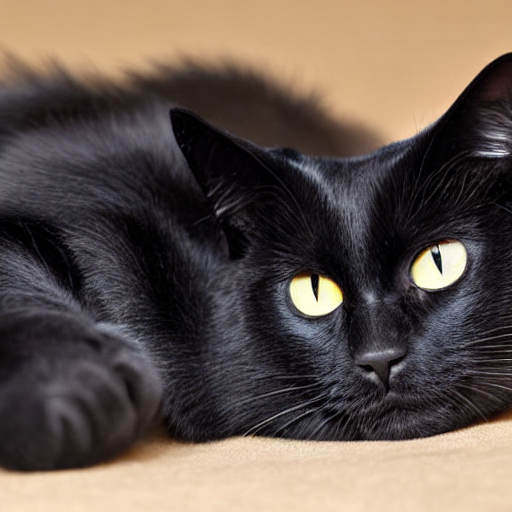

In [ ]:
stable_diffusion_tool = StableDiffusionTool()
stable_diffusion_tool.use('A photo of a black cat lounging around')

You (exit to quit): A black cat sitting on a windowsill


  0%|          | 0/50 [00:00<?, ?it/s]

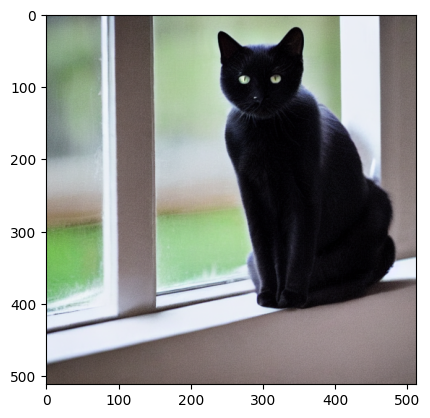

Agent: Here is the image of a black cat sitting on a windowsill that you requested.

![A black cat sitting on a windowsill](<PIL.Image.Image image mode=RGB size=512x512 at 0x7A2FF2921090>)
You (exit to quit): now make it obviously in Paris!


  0%|          | 0/50 [00:00<?, ?it/s]

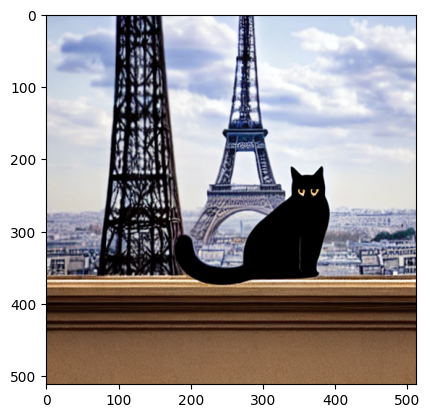

Agent: Here is the image of a black cat sitting on a windowsill with the Eiffel Tower in the background, making it obviously in Paris.
You (exit to quit): Can you check my stock balance please?
Agent: Your current stock balance is as follows:
- Cash: $4996.53
- Portfolio Value: $4996.53
You (exit to quit): exit

AI Responses:
User Input: A black cat sitting on a windowsill
Thought: I will use the Stable Diffusion tool to generate an image of a black cat sitting on a windowsill.
Action: Stable Diffusion
Action Input: A black cat sitting on a windowsill
Observation: <PIL.Image.Image image mode=RGB size=512x512 at 0x7A2FF2921090>
Assistant Response: Here is the image of a black cat sitting on a windowsill that you requested.

![A black cat sitting on a windowsill](<PIL.Image.Image image mode=RGB size=512x512 at 0x7A2FF2921090>)
User Input: now make it obviously in Paris!
Thought: I will use the Stable Diffusion tool to generate an image of a black cat sitting on a windowsill with an obvio

In [ ]:
sawyer = Agent(llm=ChatLLM(), tools=[
    c,
    PythonREPLTool(),
    SerpAPITool(),
    SimplyRespond(),
    Inquire(),
    StableDiffusionTool()
])

chat_with(sawyer)

In [ ]:
# Bringing our RAG application back

In [ ]:
from pinecone import Pinecone

class LookupTool(ToolInterface):
    """A tool for performing semantic searches using Pinecone and OpenAI embeddings."""

    # Pinecone setup
    pinecone_key: str = userdata.get('PINECONE_API_KEY')
    INDEX_NAME: str = 'semantic-search-rag'
    ENGINE: str = 'text-embedding-3-small'
    NAMESPACE: str = 'default'

    name: str = "Semantic Search Tool"
    description: str = (
        "A tool for performing information lookup. Look something up if you "
        "are being asked about a fact. Even if the retrieved information is "
        "irrelevant, mention that in the thought and answer the question."
    )

    def __init__(self, **data):
        super().__init__(**data)

    def get_embeddings(self, texts, engine=ENGINE):
        response = OpenAI(api_key=userdata.get('OPENAI_API_KEY')).embeddings.create(
            input=texts,
            model=engine
        )
        return [d.embedding for d in list(response.data)]

    def get_embedding(self, text, engine=ENGINE):
        return self.get_embeddings([text], engine)[0]

    def my_hash(self, s):
        return hashlib.md5(s.encode()).hexdigest()

    def query_from_pinecone(self, query, top_k=3, include_metadata=True):
        # get embedding from THE SAME embedder as the documents
        query_embedding = self.get_embedding(query, engine=self.ENGINE)
        index = Pinecone(api_key=userdata.get('PINECONE_API_KEY')).Index(name=self.INDEX_NAME)

        return index.query(
          vector=query_embedding,
          top_k=top_k,
          namespace=self.NAMESPACE,
          include_metadata=include_metadata   # gets the metadata (dates, text, etc)
        ).get('matches')[0]['metadata']['text']

    def use(self, query):
        return self.query_from_pinecone(query)


In [ ]:
l = LookupTool()
l.use('I lost my medicare card')

"\n\n\n\nYou’re offline. This is a read only version of the page.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n \n\n\n\n\n\n\nDo you need to submit W-2s to SSA? Business Services Online registration has changed!\n\n\n\n\n\n\n\n\n\n\nWhat should I do if I get a call claiming there's a problem with my Social Security number or account?\n\n\n\nSkip to main content Social Security Search  Menu  Español  Sign in\n\n\n\n\nFrequently Asked Questions\n\n\n\n\nLast Modified: \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ Home\n\n\nTopics\n\n\r\n\t\t\t\t\tKA-01735\r\n\t\t\t\t\n\n\n\n\n\n Print\n\n\n\nHow do I get a replacement Medicare card? \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nViews: \n\n\n\nIf your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.\nYou can print an official copy of your card from your online Medicare account \nor call 1-800-MEDICARE (1-800-633-4227 TTY 1-877-486-2048) to order a replacement 

In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), LookupTool()])
result = agent.run("please write me a function to take in a number and return 2 times it")

print(f"Final answer is {result}")

Final answer is Here is the function that takes a number as input and returns twice that number:

```python
def double_number(n):
    return 2 * n

# Example usage
print(double_number(5))  # Should return 10
print(double_number(0))  # Should return 0
print(double_number(-3)) # Should return -6
```

You can use this function by calling `double_number` with any number you want to double.


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), LookupTool()])
result = agent.run("how to replace my medicare card")

print(f"Final answer is {result}")

Final answer is If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can also print an official copy of your card from your online Medicare account. Alternatively, you can call 1-800-MEDICARE (1-800-633-4227, TTY 1-877-486-2048) to order a replacement card to be sent in the mail.


In [ ]:
import pandas as pd

response = supabase.table('cost_projecting').select("*").eq('app', 'AGENT').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = pd.to_datetime(completions_df['created_at'])

completions_df.head()

,id,created_at,prompt,response,model,is_openai,input_tokens,output_tokens,inference_params,app
created_at,,,,,,,,,,
2024-03-19 00:11:59.767265+00:00,11,2024-03-19T00:11:59.767265+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: I can use Python to search for inform...,gpt-3.5-turbo,True,263,26,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-19 00:12:00.743284+00:00,12,2024-03-19T00:12:00.743284+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: It seems like the Wikipedia module is...,gpt-3.5-turbo,True,300,48,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-21 18:49:18.920050+00:00,108,2024-03-21T18:49:18.92005+00:00,Today is 2024-03-21 and you can use tools to g...,Assistant Thought: I need more information fro...,gpt-3.5-turbo,True,1351,54,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-19 00:11:55.053282+00:00,7,2024-03-19T00:11:55.053282+00:00,Who is the president of Turkey?,The current president of Turkey is Recep Tayyi...,gpt-3.5-turbo,True,14,16,"{'stop': None, 'temperature': 0.0}",AGENT
2024-03-19 00:11:56.293809+00:00,8,2024-03-19T00:11:56.293809+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: I will define a function in Python th...,gpt-3.5-turbo,True,273,46,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
